In [13]:
import tensorflow as tf
import urllib
from python_speech_features import mfcc, delta, logfbank
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np

from os import listdir, getcwd
from os.path import join, isfile, isdir
from pprint import pprint


import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import hello_world
hello_world()

Hello World!


# RNN for Classification

For our classification problem we will use a relatively simple dataset that can be understood, the `Google Speech Data` which includes short snippets of audio data that involve certain trigger words.

While not directly applicable to Financial Services, the process of feature choice and extraction are well demonstrated by the use case choice.

In [2]:
base_data_path = join(getcwd(), "speech_data")
commands = [
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "zero"
]
dirs = [
    join(base_data_path, d) for d in listdir(base_data_path)
    if isdir(join(base_data_path, d)) and
    d in commands
]
numbers = {
    d: [ 
        join(base_data_path, d, f) for f in listdir(join(base_data_path,d))
        if f[-3:] == "wav"
    ] for d in listdir(base_data_path)
    if isdir(join(base_data_path, d)) and
    d in commands
}
pprint(dirs)

MAPPING = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "zero": 0
}

['/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/eight',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/nine',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/three',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/one',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/zero',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/seven',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/two',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/six',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/five',
 '/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/four']


In [3]:
eights = [
    join(dirs[0], f) for f in listdir(dirs[0]) if isfile(join(dirs[0], f))
    and f[-3:] == "wav"
]
eights = numbers['eight']
print(eights[0])

/Users/genl/Machine-Learning-Algorithms/04-Model Creation/speech_data/eight/bb05582b_nohash_3.wav


# Feature Extraction

Raw signal isn't always the best choice for solving a ML problem.  In this case one of the commonly accepted feature choices for audio processing is Mel-frequency cepstral coefficients or MFCC.

From: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum#:~:text=Mel%2Dfrequency%20cepstral%20coefficients%20(MFCCs,%2Da%2Dspectrum%22).

>Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC[1]. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

>MFCCs are commonly derived as follows:[2]

- Take the Fourier transform of (a windowed excerpt of) a signal.
- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
- Take the logs of the powers at each of the mel frequencies.
- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
- The MFCCs are the amplitudes of the resulting spectrum.
- There can be variations on this process, for example: differences in the shape or spacing of the windows used to map the scale,[3] or addition of dynamics features such as "delta" and "delta-delta" (first- and second-order frame-to-frame difference) coefficients.[4]

Since we're using Python, there's a library for that, `python_speech_features`, which will simplify our work.

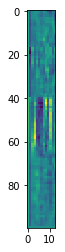

In [12]:
from python_speech_features import mfcc, delta, logfbank

def calculate_mfcc(filename: str, pad=100):
    """
    
    """
    (rate,sig) = wav.read(filename)
    mfcc_feat = mfcc(sig,rate)
    steps, feats = mfcc_feat.shape
    if steps < pad:
        mfcc_feat = np.vstack([mfcc_feat, np.zeros((pad-steps, 13))])
    else:
        mfcc_feat = mfcc_feat[:pad]
    return mfcc_feat
    
fig = plt.imshow(calculate_mfcc(eights[0]))

# Data Set Creation

Once we have our initial feature choice, we now need to create our dataset.  We will write a function which will output the dataset as a `dict`, with keys keeping track of each of the components:
- `X_train`
- `y_train`
- `X_test`
- `y_test`
- `X_val`
- `y_val`

In [7]:
def create_dataset(validation_split=0.1, test_split=0.1):
    """
    
    """
    X_train = []
    y_train = []
    X_val   = []
    y_val   = []
    X_test  = []
    y_test  = []
    
    for num in numbers:
        shuffle(numbers[num])
        total = len(numbers[num])
        num_test = int(test_split * total)
        num_val  = int(validation_split * total)
        num_train = total - num_test - num_val
        n_train, n_val, n_test = numbers[num][:num_train], \
            numbers[num][num_train:num_train+num_val], \
            numbers[num][num_train+num_val:]
        X_train.extend(n_train)
        y_train.extend([MAPPING[num] for _ in n_train])
        X_val.extend(n_val)
        y_val.extend([MAPPING[num] for _ in n_val])
        X_test.extend(n_test)
        y_test.extend([MAPPING[num] for _ in n_test])
        
    print(f"""
    Creating Training Set
    """)
    Data = list(zip(X_train, y_train))
    shuffle(Data)
    X_train, y_train = zip(*Data)
    Audio_train = []
    for idx, x in enumerate(X_train):
        Audio_train.append(calculate_mfcc(x))
        if idx % 100 == 0:
            print(".", end="")
            if idx % 5000 == 0:
                print("")
    
    print(f"""
    Creating Validation Set
    """)
    Audio_val = []
    for idx, x in enumerate(X_val):
        Audio_val.append(calculate_mfcc(x))
        if idx % 100 == 0:
            print(".", end="")
            if idx % 5000 == 0:
                print("")
    
    print(f"""
    Creating Testing Set
    """)
    Audio_test = []
    for idx, x in enumerate(X_test):
        Audio_test.append(calculate_mfcc(x))
        if idx % 100 == 0:
            print(".", end="")
            if idx % 5000 == 0:
                print("")
        
    return {
        "X_train": np.array(Audio_train),
        "y_train": y_train,
        "X_val": np.array(Audio_val),
        "y_val": y_val,
        "X_test": np.array(Audio_test),
        "y_test": y_test
    }

Data = create_dataset()

.
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
............
.......................................
......................................

In [8]:
# print(Data['X_train'].reshape(31134, 83, 13))
S = Data['X_train'].shape
Shapes = set()
for x in Data['X_train']:
    if x.shape != S:
        Shapes.add(x.shape)
        
print(Shapes)

{(100, 13)}


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (Data["X_train"], Data["y_train"]))

test_dataset = tf.data.Dataset.from_tensor_slices((Data["X_test"], Data["y_test"]))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [10]:
from tensorflow.keras import Sequential

def create_model(*args, **kwargs):
    """
    
    """
    model = Sequential([
        tf.keras.Input(shape=(100,13)),
        tf.keras.layers.LSTM(512, return_sequences=True),
        tf.keras.layers.LSTM(512),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
    )
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model
    
model = create_model()

W1106 12:58:29.016808 4653647296 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1106 12:58:29.487804 4653647296 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:127: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1077248   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 3,243,402
Trainable params: 3,243,402
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=1
)

239/487 [=============>................] - ETA: 9:39 - loss: 1652.1614 - acc: 0.3391

KeyboardInterrupt: 

# Comparison of Results

Since we have classification problem with relatively few (and balanced!) classes, accuracy is a good metric for how well a network is performing, on top of that, a confusion matrix is also a useful metric for the performance.

In [14]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


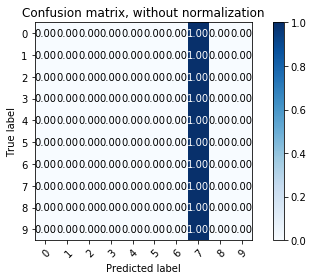

In [18]:
y_pred = model.predict_classes(Data['X_test'])
y_test = Data['y_test']
class_names=[0,1,2,3,4,5,6,7,8,9]

plot = plot_confusion_matrix(
    y_test, y_pred, classes=class_names,
    normalize=True,
    title='Confusion matrix, without normalization'
)
plt.show(plot)

Clearly this initial example performs poorly (in completely trained)

# RNN for Regression